In [81]:

import os
import json
import random
import numpy as np
import pandas as pd
import pickle
import neptune

from itertools import product
import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import itertools
import itertools
import pandas as pd
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE",
                        "#FFDD00",
                        "#FF7D00",
                        "#FF006D",
                        "#ADFF02",
                        "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime
from sklearn.metrics import accuracy_score

def save_history(history, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)

    with open(f"{PATH}/{unique_name}.json", "w+") as f0:
        json.dump(history, f0)

def get_config(file_loc):
    file = torch.load(file_loc)
    return file["model_state_dict"], file["model_config"], file["config"]
    
def save_model(model, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)
    torch.save({
        "n_epochs": config["n_epochs"],
        "model_state_dict": model.state_dict(),
        "model_config": config["model"],
        "config": config
    }, f"{PATH}/{unique_name}.pt")

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

C:\Users\User\AppData\Local\Temp\ipykernel_7724\1173221807.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):


In [82]:

import os
import json
import random
import numpy as np
import pandas as pd
import pickle
import neptune

from itertools import product
import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import itertools
import itertools
import pandas as pd
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE",
                        "#FFDD00",
                        "#FF7D00",
                        "#FF006D",
                        "#ADFF02",
                        "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime
from sklearn.metrics import accuracy_score

def save_history(history, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)

    with open(f"{PATH}/{unique_name}.json", "w+") as f0:
        json.dump(history, f0)

def get_config(file_loc):
    file = torch.load(file_loc)
    return file["model_state_dict"], file["model_config"], file["config"]
    
def save_model(model, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)
    torch.save({
        "n_epochs": config["n_epochs"],
        "model_state_dict": model.state_dict(),
        "model_config": config["model"],
        "config": config
    }, f"{PATH}/{unique_name}.pt")

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

C:\Users\User\AppData\Local\Temp\ipykernel_7724\1173221807.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):


In [83]:
class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [85]:
model_ident = "HMDB51_Mapping_unitv3_classifier_1024_emb1d"
unique_iden = "epoch50_emb400"
dataset_ident = "HMDB51"

main_dir = "../.."
data_dir = os.path.join("D:\\FYP\\VideoMAE\\preprocessed\\HMDB51_1seg_embed")
original_data_dir = "D:\\FYP\\hmdb51_org"
train_dir = os.path.join(data_dir,"train")
val_dir = os.path.join(data_dir,"val")

"""
main_dir = "../.."
data_dir = os.path.join("H:\\Academics\\MHEALTH - New\\Videos-new")
"""

epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
prototypes_save = os.path.join(main_dir,"prototypes")
test_vids = os.path.join(main_dir,"test_vids")
setting_fol = os.path.join(main_dir,"settings")
os.makedirs(f"{setting_fol}/{model_ident}",exist_ok=True)
train_ratio = 0.90
val_ratio = 0.1
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

class_names = os.listdir(original_data_dir)

In [86]:
config = {
    "n_epochs":50,
    "model_name":"BidirectionalLSTM",
    "model":{
        "num_joint":12,
        "seq_len":60,
        "decoder_hidden_size":1024,
        "linear_filters":[128,256,512,1024],
        "embedding_size":400,
        "num_classes":len(class_names),
        "num_layers":1,
        "is_3d":False,
        "bidirectional":True,
        "batch_size":batch_size,
        "dev":device,
        "device":"gpu" if torch.cuda.is_available() else "cpu"
        },
    "lr":1e-3,
    'alpha_target': 0.0
}

id2clsname, clsname2id = classname_id(class_names)

In [87]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

run['parameters'] = config

https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-283


In [88]:
config

{'n_epochs': 50,
 'model_name': 'BidirectionalLSTM',
 'model': {'num_joint': 12,
  'seq_len': 60,
  'decoder_hidden_size': 1024,
  'linear_filters': [128, 256, 512, 1024],
  'embedding_size': 400,
  'num_classes': 51,
  'num_layers': 1,
  'is_3d': False,
  'bidirectional': True,
  'batch_size': 32,
  'dev': device(type='cuda'),
  'device': 'gpu'},
 'lr': 0.001,
 'alpha_target': 0.0}

In [89]:
import os
import numpy as np
from numpy.lib.function_base import disp
import torch
import decord
from PIL import Image
from torchvision import transforms
from random_erasing import RandomErasing
import warnings
from decord import VideoReader, cpu
from torch.utils.data import Dataset
import video_transforms as video_transforms 
import volume_transforms as volume_transforms
from kinetics import *

class VideoNumpyDataset(Dataset):
  def __init__(self,data_folder) -> None:
      super(VideoNumpyDataset,self).__init__()
      self.datafolder = data_folder
      self.files = [os.path.join(self.datafolder,x) for x in os.listdir(self.datafolder)]

  def __getitem__(self, index):
    arrays = np.load(self.files[index])
    video = arrays["embedding"]
    label = arrays["label"]
    id = arrays["id"]
    chunk_nb = arrays["chunk_nb"]
    split_nb = arrays["split_nb"]
    return video,clsname2id[str(label)],str(id),chunk_nb, split_nb


  def __len__(self):
    return len(self.files)

In [90]:
test_mode = True
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]

train_dataset = VideoNumpyDataset(train_dir)

val_dataset = VideoNumpyDataset(val_dir)


train_dl = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=batch_size,
            drop_last=False
            )

val_dl = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=batch_size,
            drop_last=False
            )

In [91]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [107]:
from functools import partial
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.layers import trunc_normal_ as __call_trunc_normal_
from timm.models.registry import register_model
import torch.utils.checkpoint as checkpoint
import math

def pretrain_trunc_normal_(tensor, mean=0., std=1.):
    __call_trunc_normal_(tensor, mean=mean, std=std, a=-std, b=std)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 400, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5),
        **kwargs
    }


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement 
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, num_frames=16, tubelet_size=2):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.tubelet_size = int(tubelet_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (num_frames // self.tubelet_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv3d(in_channels=in_chans, out_channels=embed_dim, 
                            kernel_size = (self.tubelet_size,  patch_size[0],patch_size[1]), 
                            stride=(self.tubelet_size,  patch_size[0],  patch_size[1]))

    def forward(self, x, **kwargs):
        B, C, T, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    
# sin-cos position encoding
# https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py#L31
def get_sinusoid_encoding_table(n_position, d_hid): 
    ''' Sinusoid position encoding table ''' 
    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position): 
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)] 

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)]) 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # dim 2i 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # dim 2i+1 

    return  torch.tensor(sinusoid_table,dtype=torch.float, requires_grad=False).unsqueeze(0) 


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 in_chans=3, 
                 num_classes=1000, 
                 embed_dim=768, 
                 depth=12,
                 num_heads=12, 
                 mlp_ratio=4., 
                 qkv_bias=False, 
                 qk_scale=None, 
                 fc_drop_rate=0., 
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0., 
                 norm_layer=nn.LayerNorm, 
                 init_values=0.,
                 use_learnable_pos_emb=False, 
                 init_scale=0.,
                 all_frames=16,
                 tubelet_size=2,
                 use_checkpoint=False,
                 use_mean_pooling=True):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.tubelet_size = tubelet_size
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, num_frames=all_frames, tubelet_size=self.tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.use_checkpoint = use_checkpoint

        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        else:
            # sine-cosine positional embeddings is on the way
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        self.pos_drop = nn.Dropout(p=drop_rate)


        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None
        self.fc_dropout = nn.Dropout(p=fc_drop_rate) if fc_drop_rate > 0 else nn.Identity()
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if use_learnable_pos_emb:
            pretrain_trunc_normal_(self.pos_embed, std=.02)

        pretrain_trunc_normal_(self.head.weight, std=.02)
        self.apply(self._init_weights)

        self.head.weight.data.mul_(init_scale)
        self.head.bias.data.mul_(init_scale)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            pretrain_trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        B, _, _ = x.size()

        if self.pos_embed is not None:
            x = x + self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        x = self.pos_drop(x)

        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
        else:   
            for blk in self.blocks:
                x = blk(x)

        x = self.norm(x)
        if self.fc_norm is not None:
            return self.fc_norm(x.mean(1))
        else:
            return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(self.fc_dropout(x))
        return x


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_512(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=512, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model

class PretrainVisionTransformerEncoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None, tubelet_size=2, use_checkpoint=False,
                 use_learnable_pos_emb=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,tubelet_size=tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.use_checkpoint = use_checkpoint


        # TODO: Add the cls token
        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            # sine-cosine positional embeddings 
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if use_learnable_pos_emb:
            pretrain_trunc_normal_(self.pos_embed, std=.02)

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        _, _, T, _, _ = x.shape
        x = self.patch_embed(x)
        
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach()

        B, _, C = x.shape
        x_vis = x.reshape(B, -1, C) # ~mask means visible

        if self.use_checkpoint:
            for blk in self.blocks:
                x_vis = checkpoint.checkpoint(blk, x_vis)
        else:   
            for blk in self.blocks:
                x_vis = blk(x_vis)

        x_vis = self.norm(x_vis)
        return x_vis

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class PretrainVisionTransformerDecoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, patch_size=16, num_classes=768, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 norm_layer=nn.LayerNorm, init_values=None, num_patches=196, tubelet_size=2, use_checkpoint=False
                 ):
        super().__init__()
        self.num_classes = num_classes
        assert num_classes == 3 * tubelet_size * patch_size ** 2 
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_size = patch_size
        self.use_checkpoint = use_checkpoint


        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, return_token_num):
        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
        else:   
            for blk in self.blocks:
                x = blk(x)

        if return_token_num > 0:
            x = self.head(self.norm(x[:, -return_token_num:])) # only return the mask tokens predict pixels
        else:
            x = self.head(self.norm(x))

        return x

class PretrainVisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self,
                 img_size=224, 
                 patch_size=16, 
                 encoder_in_chans=3, 
                 encoder_num_classes=0, 
                 encoder_embed_dim=768, 
                 encoder_depth=12,
                 encoder_num_heads=12, 
                 decoder_num_classes=1536, #  decoder_num_classes=768, 
                 decoder_embed_dim=512, 
                 decoder_depth=8,
                 decoder_num_heads=8, 
                 mlp_ratio=4., 
                 qkv_bias=False, 
                 qk_scale=None, 
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0., 
                 norm_layer=nn.LayerNorm, 
                 init_values=0.,
                 use_learnable_pos_emb=False,
                 use_checkpoint=False,
                 tubelet_size=2,
                 num_classes=0, # avoid the error from create_fn in timm
                 in_chans=0, # avoid the error from create_fn in timm
                 ):
        super().__init__()
        self.encoder = PretrainVisionTransformerEncoder(
            img_size=img_size, 
            patch_size=patch_size, 
            in_chans=encoder_in_chans, 
            num_classes=encoder_num_classes, 
            embed_dim=encoder_embed_dim, 
            depth=encoder_depth,
            num_heads=encoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values,
            tubelet_size=tubelet_size,
            use_checkpoint=use_checkpoint,
            use_learnable_pos_emb=use_learnable_pos_emb)

        self.decoder = PretrainVisionTransformerDecoder(
            patch_size=patch_size, 
            num_patches=self.encoder.patch_embed.num_patches,
            num_classes=decoder_num_classes, 
            embed_dim=decoder_embed_dim, 
            depth=decoder_depth,
            num_heads=decoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values,
            tubelet_size=tubelet_size,
            use_checkpoint=use_checkpoint)

        self.encoder_to_decoder = nn.Linear(encoder_embed_dim, decoder_embed_dim, bias=False)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.pos_embed = get_sinusoid_encoding_table(self.encoder.patch_embed.num_patches, decoder_embed_dim)

        trunc_normal_(self.mask_token, std=.02)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'mask_token'}

    def forward(self, x):
        _, _, T, _, _ = x.shape
        x_vis = self.encoder(x) # [B, N_vis, C_e]
        x_vis = self.encoder_to_decoder(x_vis) # [B, N_vis, C_d]
        B, N, C = x_vis.shape
        # we don't unshuffle the correct visible token order, 
        # but shuffle the pos embedding accorddingly.
        expand_pos_embed = self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        pos_emd_vis = expand_pos_embed.reshape(B, -1, C)
        pos_emd_mask = expand_pos_embed.reshape(B, -1, C)
        x_full = torch.cat([x_vis + pos_emd_vis, self.mask_token + pos_emd_mask], dim=1) # [B, N, C_d]
        x = self.decoder(x_full, pos_emd_mask.shape[1]) # [B, N_mask, 3 * 16 * 16]

        return x

@register_model
def pretrain_videomae_small_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=384,
        encoder_depth=12,
        encoder_num_heads=6,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=192, 
        decoder_num_heads=3,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def pretrain_videomae_base_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=768, 
        encoder_depth=12, 
        encoder_num_heads=12,
        encoder_num_classes=0,
        decoder_num_classes=1536,
        decoder_embed_dim=384,
        decoder_num_heads=6,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model
 
@register_model
def pretrain_videomae_large_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=1024, 
        encoder_depth=24, 
        encoder_num_heads=16,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=512,
        decoder_num_heads=8,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def pretrain_videomae_huge_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=1280, 
        encoder_depth=32, 
        encoder_num_heads=16,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=640,
        decoder_num_heads=8,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

class DecoderMappingV3(nn.Module):
  def __init__(self,embedding_dim, *args, **kwargs) -> None:
      super(DecoderMappingV3,self).__init__(*args, **kwargs)
      
      self.conv1 = nn.ConvTranspose2d(8,1,kernel_size=3,stride=2,dilation=2)
      self.conv2 = nn.ConvTranspose2d(8,8,kernel_size=3,stride=2,dilation=2)
      self.conv3 = nn.ConvTranspose2d(16,8,kernel_size=3,stride=2,dilation=2)
      self.conv4 = nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,dilation=2)
      self.conv5 = nn.ConvTranspose2d(32,32,kernel_size=3,stride=1,dilation=2)
      
      self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
      self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
      
      self.linear1 = nn.Linear(549,384)
      self.linear2 = nn.Linear(1573,1568)
      
      self.embed = nn.Linear(embedding_dim,32*19*3)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1,output_padding=0):
    lout = (lin-1)*stride-2*padding+dilation*(kernal_size - 1) + output_padding+1
    return lout

  def forward(self,x):
    x = self.embed(x)
    x = x.reshape(-1,32,19,3)
    x = self.conv5(x)
    x = self.upsample2(x)
    x = self.conv4(x)
    x = self.upsample1(x)
    x = self.conv3(x)
    x = self.conv2(x)
    
    x = self.conv1(x)
    x = torch.transpose(x,-2,-1)
    x = self.linear2(x)
    x = torch.transpose(x,-2,-1)
    x = self.linear1(x).squeeze()
    return x
  



class VideoDecoder(nn.Module):
  def __init__(self,backbone_decoder,map_unit,encoder_to_decoder, *args, **kwargs) -> None:
      super(VideoDecoder,self).__init__(*args, **kwargs)
      self.decoder = backbone_decoder
      self.encoder_to_decoder = encoder_to_decoder
      self.map_unit = map_unit

      self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder.embed_dim))

      self.pos_embed = get_sinusoid_encoding_table(1568, self.decoder.embed_dim)

      trunc_normal_(self.mask_token, std=.02)

  def forward(self,x):
    x_vis = self.map_unit(x)
    x_vis = self.encoder_to_decoder(x_vis) # [B, N_vis, C_d]
    B, N, C = x_vis.shape
    # we don't unshuffle the correct visible token order, 
    # but shuffle the pos embedding accorddingly.
    expand_pos_embed = self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
    pos_emd_vis = expand_pos_embed.reshape(B, -1, C)
    pos_emd_mask = expand_pos_embed.reshape(B, -1, C)
    x_full = torch.cat([x_vis + pos_emd_vis, self.mask_token + pos_emd_mask], dim=1) # [B, N, C_d]
    x = self.decoder(x_full, pos_emd_mask.shape[1]) # [B, N_mask, 3 * 16 * 16]
    
    return x

class SGNClassifier(nn.Module):
  def __init__(self,num_classes,embedding_size, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)
      self.num_classes = num_classes
      self.embedding_size = embedding_size
      self.fc = nn.Linear(self.embedding_size, self.num_classes)

  def forward(self, input):
      output = self.fc(input)
      return output
    


class EncDecModel(nn.Module):
    def __init__(self,encoder,decoder,classifier):
        super(EncDecModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        
    def forward(self,x):
        embedding = self.encoder(x)
        classifier_out = self.classifier(embedding)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding, classifier_out

class EncoderMappingV1(nn.Module):
  def __init__(self,encoder_embed_dim,num_patches,embedding_dim, *args, **kwargs) -> None:
      super(EncoderMappingV1,self).__init__(*args, **kwargs)
      input_dim = encoder_embed_dim

      lout1 = EncoderMappingV1.calc_lout(num_patches,512,3,input_dim,stride=2)
      lout2 = EncoderMappingV1.calc_lout(512,128,3,lout1,stride=1)

      self.attn1 = Attention(
            lout2, num_heads=12)
      self.linear1 = nn.Linear(lout2,128)
      
      self.attn2 = Attention(
            128, num_heads=12)
      self.linear2 = nn.Linear(128,32)
      
      self.conv1 = nn.Conv1d(num_patches,512,3, stride=2)
      self.conv2 = nn.Conv1d(512,128,3, stride=1)

      self.linear3 = nn.Linear(32*128,1024)
      self.embed = nn.Linear(1024,embedding_dim)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1):
    lout = (lin+2*padding-dilation*(kernal_size-1)-1)//stride+1
    return lout

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    
    x = self.attn1(x)
    x = self.linear1(x)
    x = self.attn2(x)
    x = self.linear2(x)

    x = x.flatten(1)
    
    x = self.linear3(x)
    x = self.embed(x)
    return x



class DecoderMappingV1(nn.Module):
  def __init__(self,encoder_embed_dim,num_patches,embedding_dim, *args, **kwargs) -> None:
      super(DecoderMappingV1,self).__init__(*args, **kwargs)
      input_dim = encoder_embed_dim

      lout2 = DecoderMappingV1.calc_lout(128,512,3,input_dim,stride=1)
      lout1 = DecoderMappingV1.calc_lout(512,num_patches,3,lout2,stride=2)

      self.attn1 = Attention(
            input_dim, num_heads=12)
      self.linear1 = nn.Linear(128,input_dim)
      
      self.attn2 = Attention(
            128, num_heads=12)
      self.linear2 = nn.Linear(32,128)
      
      self.conv1 = nn.ConvTranspose1d(512,num_patches,3, stride=2)
      self.conv2 = nn.ConvTranspose1d(128,512,3, stride=1)

      self.linear3 = nn.Linear(1024,32*128)
      self.embed = nn.Linear(embedding_dim,1024)
      self.linear4 = nn.Linear(lout1,input_dim)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1,output_padding=0):
    lout = (lin-1)*stride-2*padding+dilation*(kernal_size - 1) + output_padding+1
    return lout

  def forward(self,x):
    x = self.embed(x)
    x = self.linear3(x)
    x = x.reshape(-1,128,32)

    x = self.linear2(x)
    x = self.attn2(x)
    x = self.linear1(x)
    x = self.attn1(x)


    x = self.conv2(x)
    x = self.conv1(x)
    x = self.linear4(x)
    
    return x
  
  
  
class EncoderMappingV2(nn.Module):
  def __init__(self,encoder_embed_dim,num_patches,embedding_dim, *args, **kwargs) -> None:
      super(EncoderMappingV2,self).__init__(*args, **kwargs)
      self.pool1 = nn.AveragePool1d
      self.embed = nn.Linear(num_patches*encoder_embed_dim,embedding_dim)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1):
    lout = (lin+2*padding-dilation*(kernal_size-1)-1)//stride+1
    return lout

  def forward(self,x):
    x = x.flatten(1)
    x = self.embed(x)
    return x



class DecoderMappingV2(nn.Module):
  def __init__(self,encoder_embed_dim,num_patches,embedding_dim, *args, **kwargs) -> None:
      super(DecoderMappingV2,self).__init__(*args, **kwargs)
      
      self.num_patches = num_patches
      self.encoder_embed_dim = encoder_embed_dim

      self.linear1 = nn.Linear(embedding_dim,num_patches*encoder_embed_dim)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1,output_padding=0):
    lout = (lin-1)*stride-2*padding+dilation*(kernal_size - 1) + output_padding+1
    return lout

  def forward(self,x):
    x = self.embed(x)
    x = x.reshape(-1,self.num_patches,self.encoder_embed_dim)
    return x
  
  

class EncoderMappingV3(nn.Module):
  def __init__(self,embedding_dim, *args, **kwargs) -> None:
      super(EncoderMappingV3,self).__init__(*args, **kwargs)
      self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,dilation=2)
      self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=2,dilation=2)
      self.conv3 = nn.Conv2d(32,32,kernel_size=3,stride=2,dilation=2)
      self.pool1 = nn.AvgPool2d(3)
      self.pool2 = nn.AvgPool2d(3)
      
      self.embed = nn.Linear(32*19*3,embedding_dim)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1):
    lout = (lin+2*padding-dilation*(kernal_size-1)-1)//stride+1
    return lout

  def forward(self,x):
    x = x.unsqueeze(1)
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = x.flatten(1)
    x = self.embed(x)
    return x



class DecoderMappingV3(nn.Module):
  def __init__(self,embedding_dim, *args, **kwargs) -> None:
      super(DecoderMappingV3,self).__init__(*args, **kwargs)
      
      self.conv1 = nn.ConvTranspose2d(8,1,kernel_size=3,stride=2,dilation=2)
      self.conv2 = nn.ConvTranspose2d(8,8,kernel_size=3,stride=2,dilation=2)
      self.conv3 = nn.ConvTranspose2d(16,8,kernel_size=3,stride=2,dilation=2)
      self.conv4 = nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,dilation=2)
      self.conv5 = nn.ConvTranspose2d(32,32,kernel_size=3,stride=1,dilation=2)
      
      self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
      self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
      
      self.linear1 = nn.Linear(549,384)
      self.linear2 = nn.Linear(1573,1568)
      
      self.embed = nn.Linear(embedding_dim,32*19*3)

  @staticmethod
  def calc_lout(cin,cout,kernal_size,lin,stride=1,padding=0,dilation=1,output_padding=0):
    lout = (lin-1)*stride-2*padding+dilation*(kernal_size - 1) + output_padding+1
    return lout

  def forward(self,x):
    x = self.embed(x)
    x = x.reshape(-1,32,19,3)
    x = self.conv5(x)
    x = self.upsample2(x)
    x = self.conv4(x)
    x = self.upsample1(x)
    x = self.conv3(x)
    x = self.conv2(x)
    
    x = self.conv1(x)
    x = torch.transpose(x,-2,-1)
    x = self.linear2(x)
    x = torch.transpose(x,-2,-1)
    x = self.linear1(x).squeeze()
    return x


In [ ]:
ae = PretrainVisionTransformer(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=384,
        encoder_depth=12,
        encoder_num_heads=6,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=192, 
        decoder_num_heads=3,
        mlp_ratio=4,
        decoder_depth=4,
        drop_path_rate=0.0,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        use_checkpoint=False
        )
ae.default_cfg = _cfg()

ae_params = torch.load(
    "videomae_pretrained_weights/ae_small_pretrained_kinetic400_1600e_.pth",
    map_location=device
    )

In [93]:
config["model"]["hidden_split"] = (128,64)

In [94]:
encoder = EncoderMappingV3(config["model"]["embedding_size"]).to(device)

classifier = SGNClassifier(
    num_classes=len(class_names),
    embedding_size=config["model"]["embedding_size"],
).to(device)

decoder = DecoderMappingV3(config["model"]["embedding_size"]).to(device)

model = EncDecModel(
    encoder = encoder,
    decoder = decoder,
    classifier = classifier
).to(device)

In [95]:
decoder(torch.rand(32,400).to(device)).shape

torch.Size([32, 1568, 384])

In [96]:
import torchinfo

torchinfo.summary(decoder, input_size=(32,400), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DecoderMappingV3                         [32, 400]                 [32, 1568, 384]           --                        --                        --
├─Linear: 1-1                            [32, 400]                 [32, 1824]                731,424                   --                        23,405,568
├─ConvTranspose2d: 1-2                   [32, 32, 19, 3]           [32, 32, 23, 7]           9,248                     [3, 3]                    47,645,696
├─Upsample: 1-3                          [32, 32, 23, 7]           [32, 32, 46, 14]          --                        --                        --
├─ConvTranspose2d: 1-4                   [32, 32, 46, 14]          [32, 16, 97, 33]          8,208                     [4, 4]                    840,761,856
├─Upsample: 1-5                          [32, 16, 97, 33]          [32, 16, 194,

In [97]:
model.to(device);

In [98]:
label_map = [(k,v) for k,v in id2clsname.items()]
labelToId = {x[0]: i for i, x in enumerate(label_map)}

In [99]:
def combined_loss(pred_sequence,pred_label,true_sequence,true_label,loss_module,alpha_target=1,alpha_recon=1):
    recon_loss = alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence)
    tar_loss = alpha_target*loss_module["target_loss"](pred_label,true_label)
    loss =  recon_loss + tar_loss

    #print(alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence))
    #print(alpha_target*loss_module["target_loss"](pred_label,true_label))

    return loss, {
        "reconstruction_loss":recon_loss.item(),
        "target_loss":tar_loss.item()
    }



In [100]:
optimizer = torch.optim.Adam(model.parameters(), 
    lr=config["lr"], 
    weight_decay=0.01)
std_loss = {
    "reconstruction_loss" :nn.MSELoss(),
    "target_loss" :nn.CrossEntropyLoss()
}

In [101]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [102]:
from einops import rearrange

def train_step(model, dataloader, optimizer, loss_module, device, class_names):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    targets = []
    predicts = []

    with tqdm(dataloader, unit="batch", desc="train") as tepoch:
          for input_sequence, target_action, id, chunk_nb, split_nb in tepoch:
            input_sequence = input_sequence.to(device)
            target_sequence = input_sequence
            target_action = target_action.to(device)
            

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(True):
            # with autocast():
              predicted_sequence, _, predicted_label  = model(input_sequence)
            
            # loss,loss_detail = combined_loss(predicted_sequence,predicted_label, target_sequence, target_action,std_loss)
            recon_loss = loss_module["reconstruction_loss"](predicted_sequence,target_sequence)
            tar_loss = loss_module["target_loss"](predicted_label,target_action)
            loss =  (1-config['alpha_target'])*recon_loss + config['alpha_target']*tar_loss
            loss_detail = {"reconstruction_loss":recon_loss.item(),"target_loss":tar_loss.item()}

            class_output = torch.argmax(predicted_label,dim=1)

            loss.backward()
            optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(target_action)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=target_action.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

            targets.append(target_action.cpu().detach().numpy())
            predicts.append(pred_class)

    
    predicts = np.concatenate(predicts)
    targets = np.concatenate(targets)
    #train_metrics = action_evaluator(predicts,targets,class_names=list(clsname2id.keys()),print_report=False)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [103]:
def eval_step(model, dataloader,loss_module, device, class_names,  print_report=False, show_plot=False):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'targets': [], 'predictions': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with torch.no_grad():
      with tqdm(dataloader, unit="batch", desc="eval") as tepoch:
        for input_sequence, target_action, id, chunk_nb, split_nb in tepoch:

            input_sequence = input_sequence.to(device)
            target_sequence = input_sequence
            target_action = target_action.to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(False):
            # with autocast():
                predicted_sequence,_,predicted_label  = model(input_sequence)
            # loss,loss_detail = combined_loss(predicted_sequence,predicted_label, target_sequence, target_action,std_loss)
            recon_loss = loss_module["reconstruction_loss"](predicted_sequence,target_sequence)
            tar_loss = loss_module["target_loss"](predicted_label,target_action)
            loss =  (1-config['alpha_target'])*recon_loss + config['alpha_target']*tar_loss
            loss_detail = {"reconstruction_loss":recon_loss.item(),"target_loss":tar_loss.item()}
            
            pred_action = torch.argmax(predicted_label,dim=1)

            with torch.no_grad():
                metrics['samples'] += len(target_action)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += loss_detail["reconstruction_loss"]
                metrics['classi. loss'] += loss_detail["target_loss"]

            per_batch['targets'].append(target_action.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [104]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v)

In [108]:
start_epoch = 8
model_params, model_config, config = get_config(f"{models_saves}/temp_{model_ident}/{start_epoch}__{unique_iden}.pt")
model.load_state_dict(model_params)

<All keys matched successfully>

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

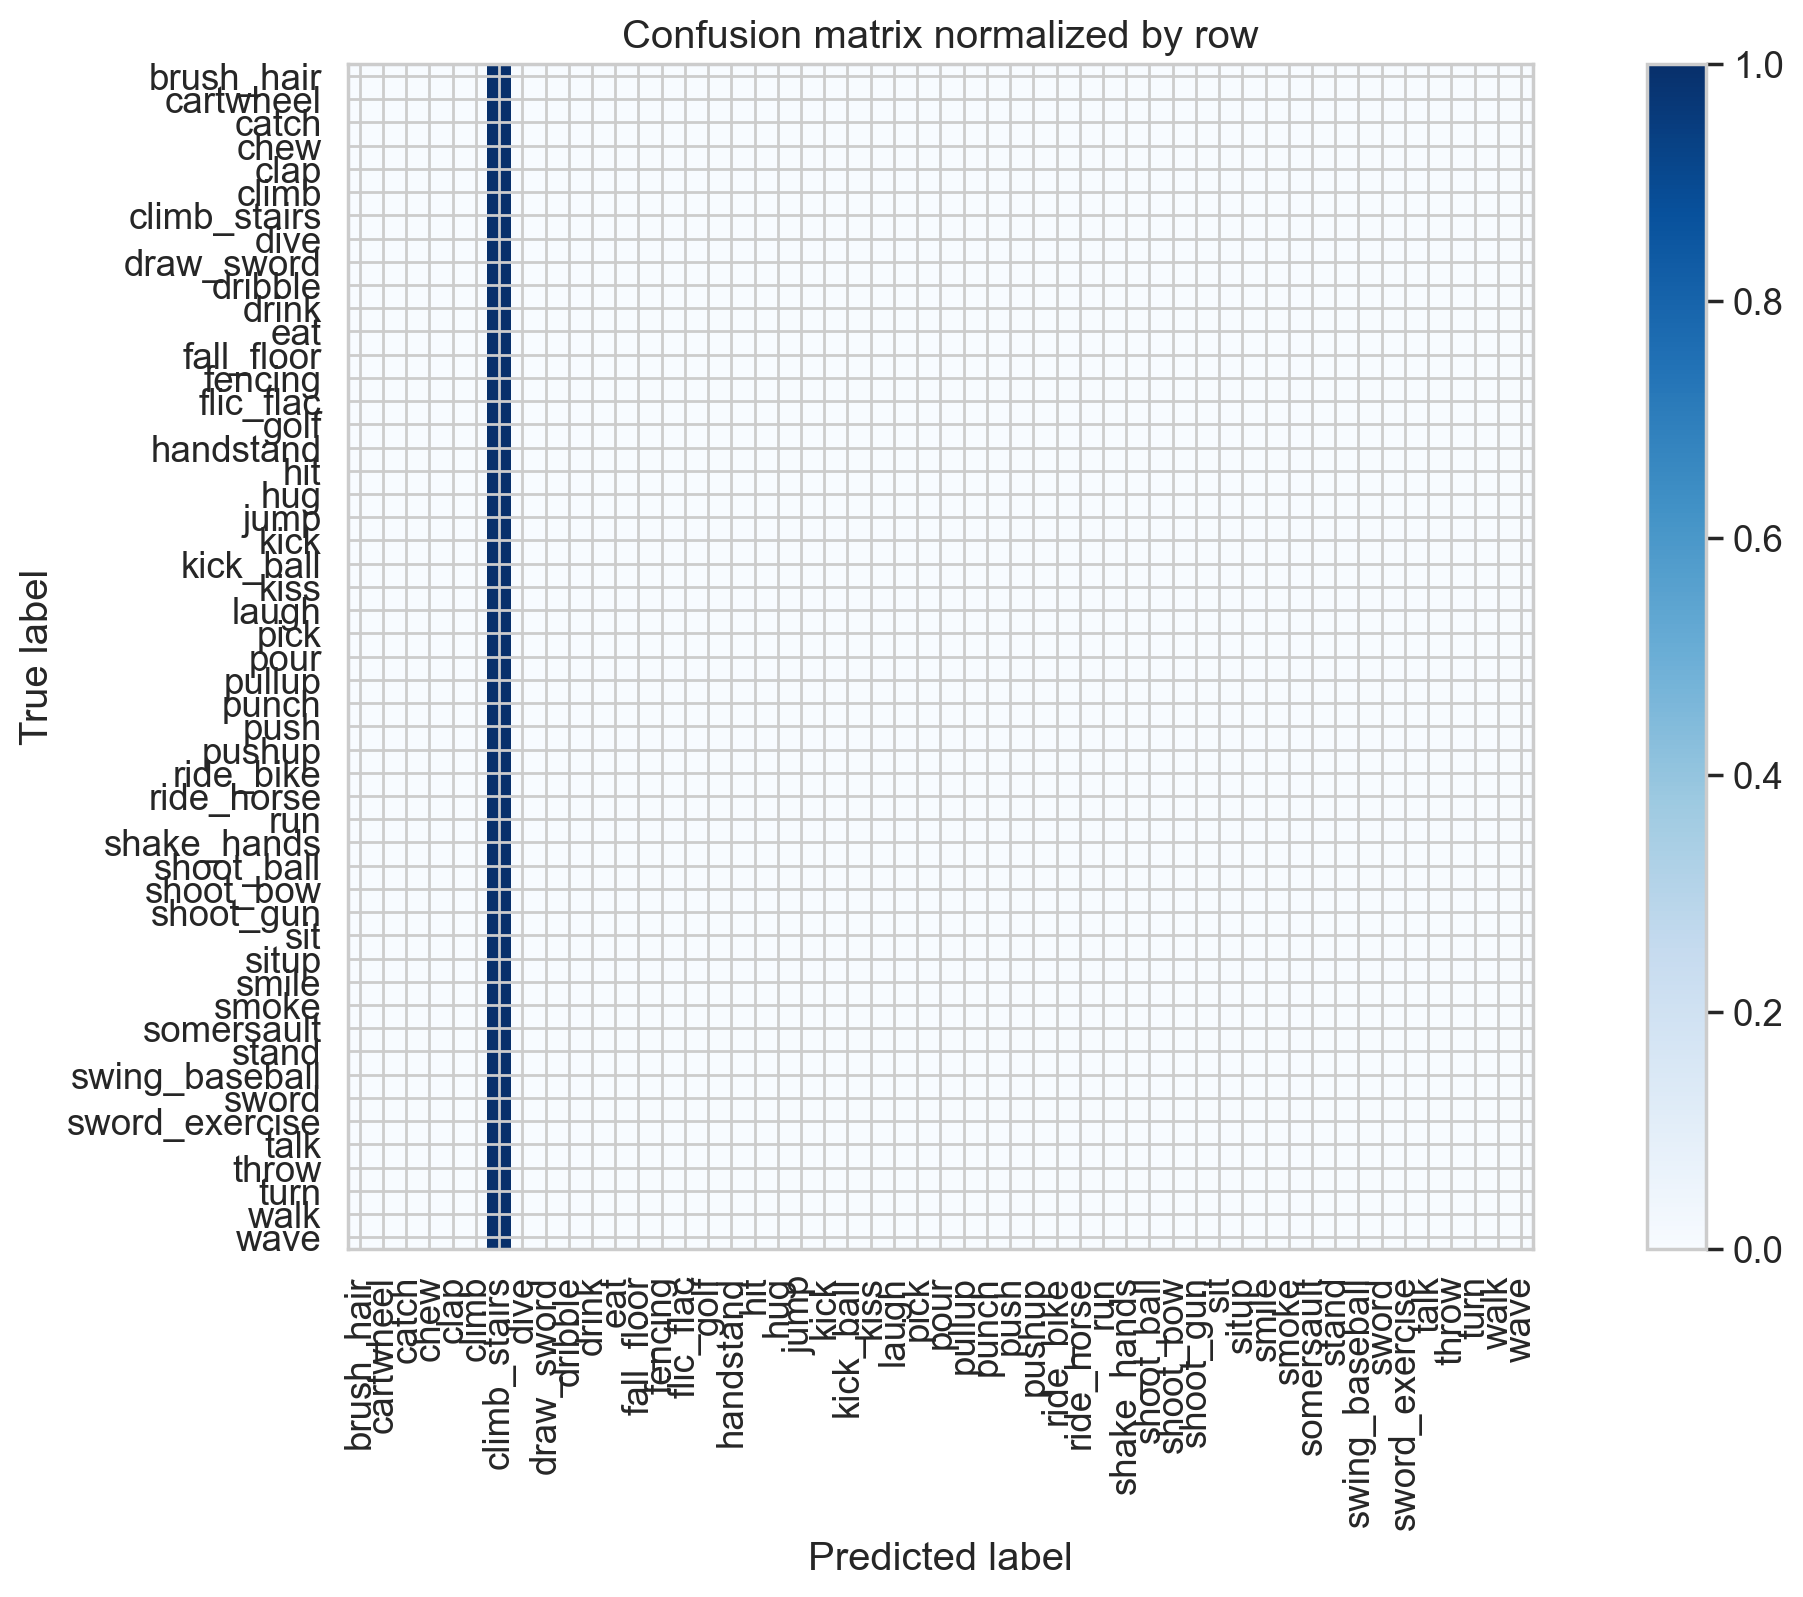

Overall accuracy: 0.017

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walk       0.000      0.000      0.000      0.079         55|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           run       0.000      0.000      0.000      0.034         24|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          turn       0.000      0.000      0.000      0.034         24|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         drink       0.000      0.000      0.000      0.024         17|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
   shake_hands       0.000      0.000      0.000      0.024         17|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          jump       0.000      0.000      0.000      0.023         16|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         stand       0.000      0.000      0.000      0.023         16|	 climb_stairs: 1.000,	wave: 0.000,	fall_floor: 0.00

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.019



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.023



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

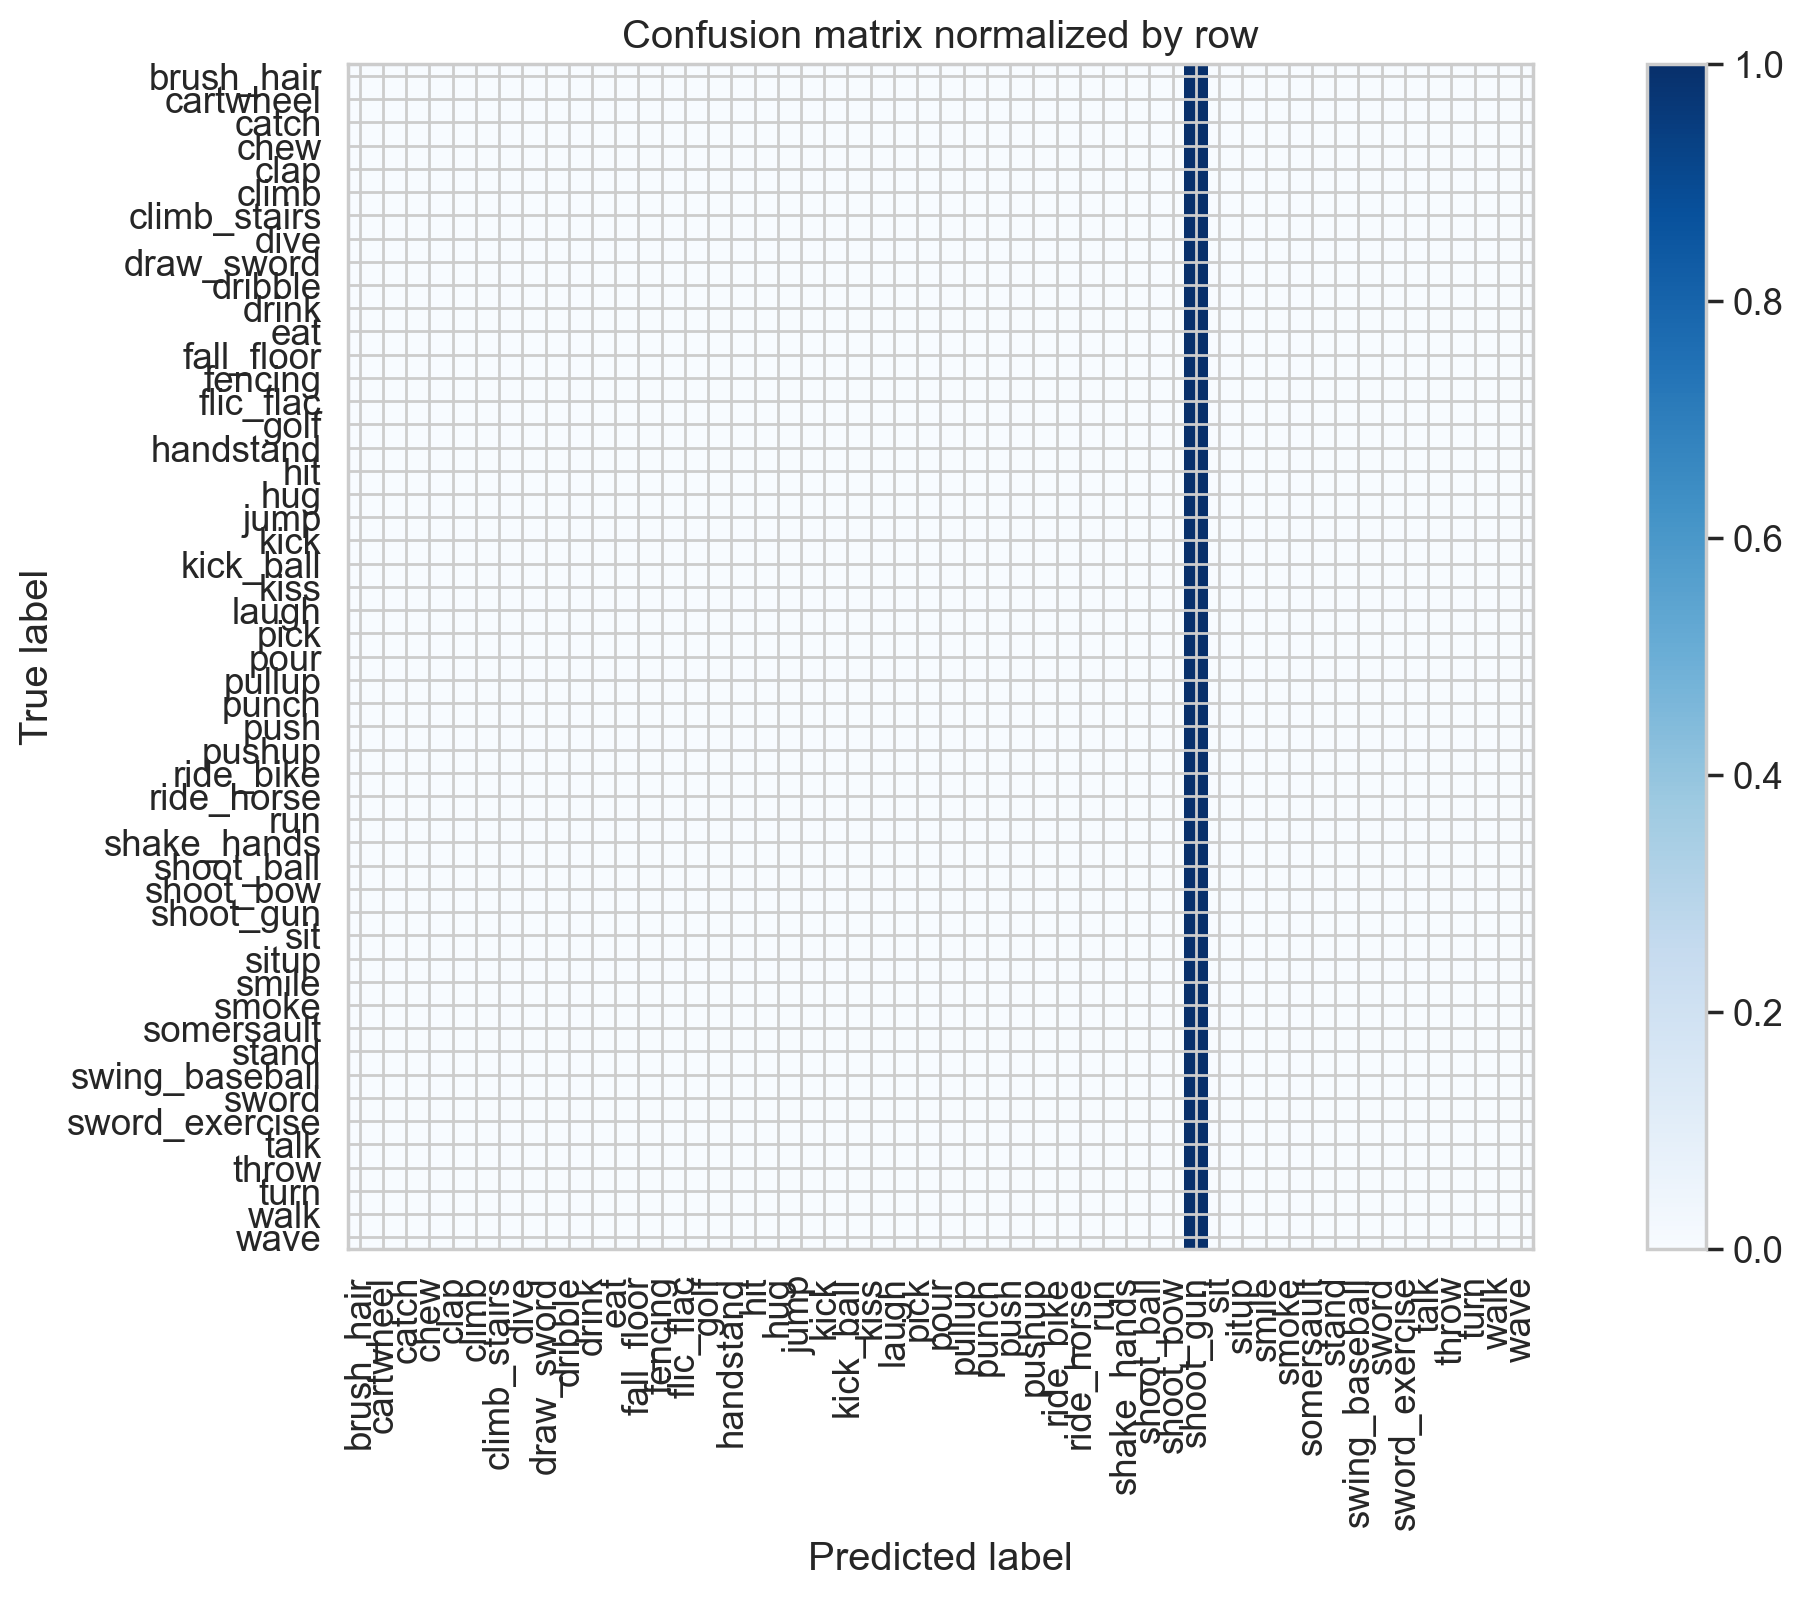

Overall accuracy: 0.016

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walk       0.000      0.000      0.000      0.079         55|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
           run       0.000      0.000      0.000      0.034         24|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
          turn       0.000      0.000      0.000      0.034         24|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
         drink       0.000      0.000      0.000      0.024         17|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
   shake_hands       0.000      0.000      0.000      0.024         17|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
          jump       0.000      0.000      0.000      0.023         16|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
         stand       0.000      0.000      0.000      0.023         16|	 shoot_gun: 1.000,	wave: 0.000,	pick: 0.000,	
           sit       0.000      0.000      0.000      0.021

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.021



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.024



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.023



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.019



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

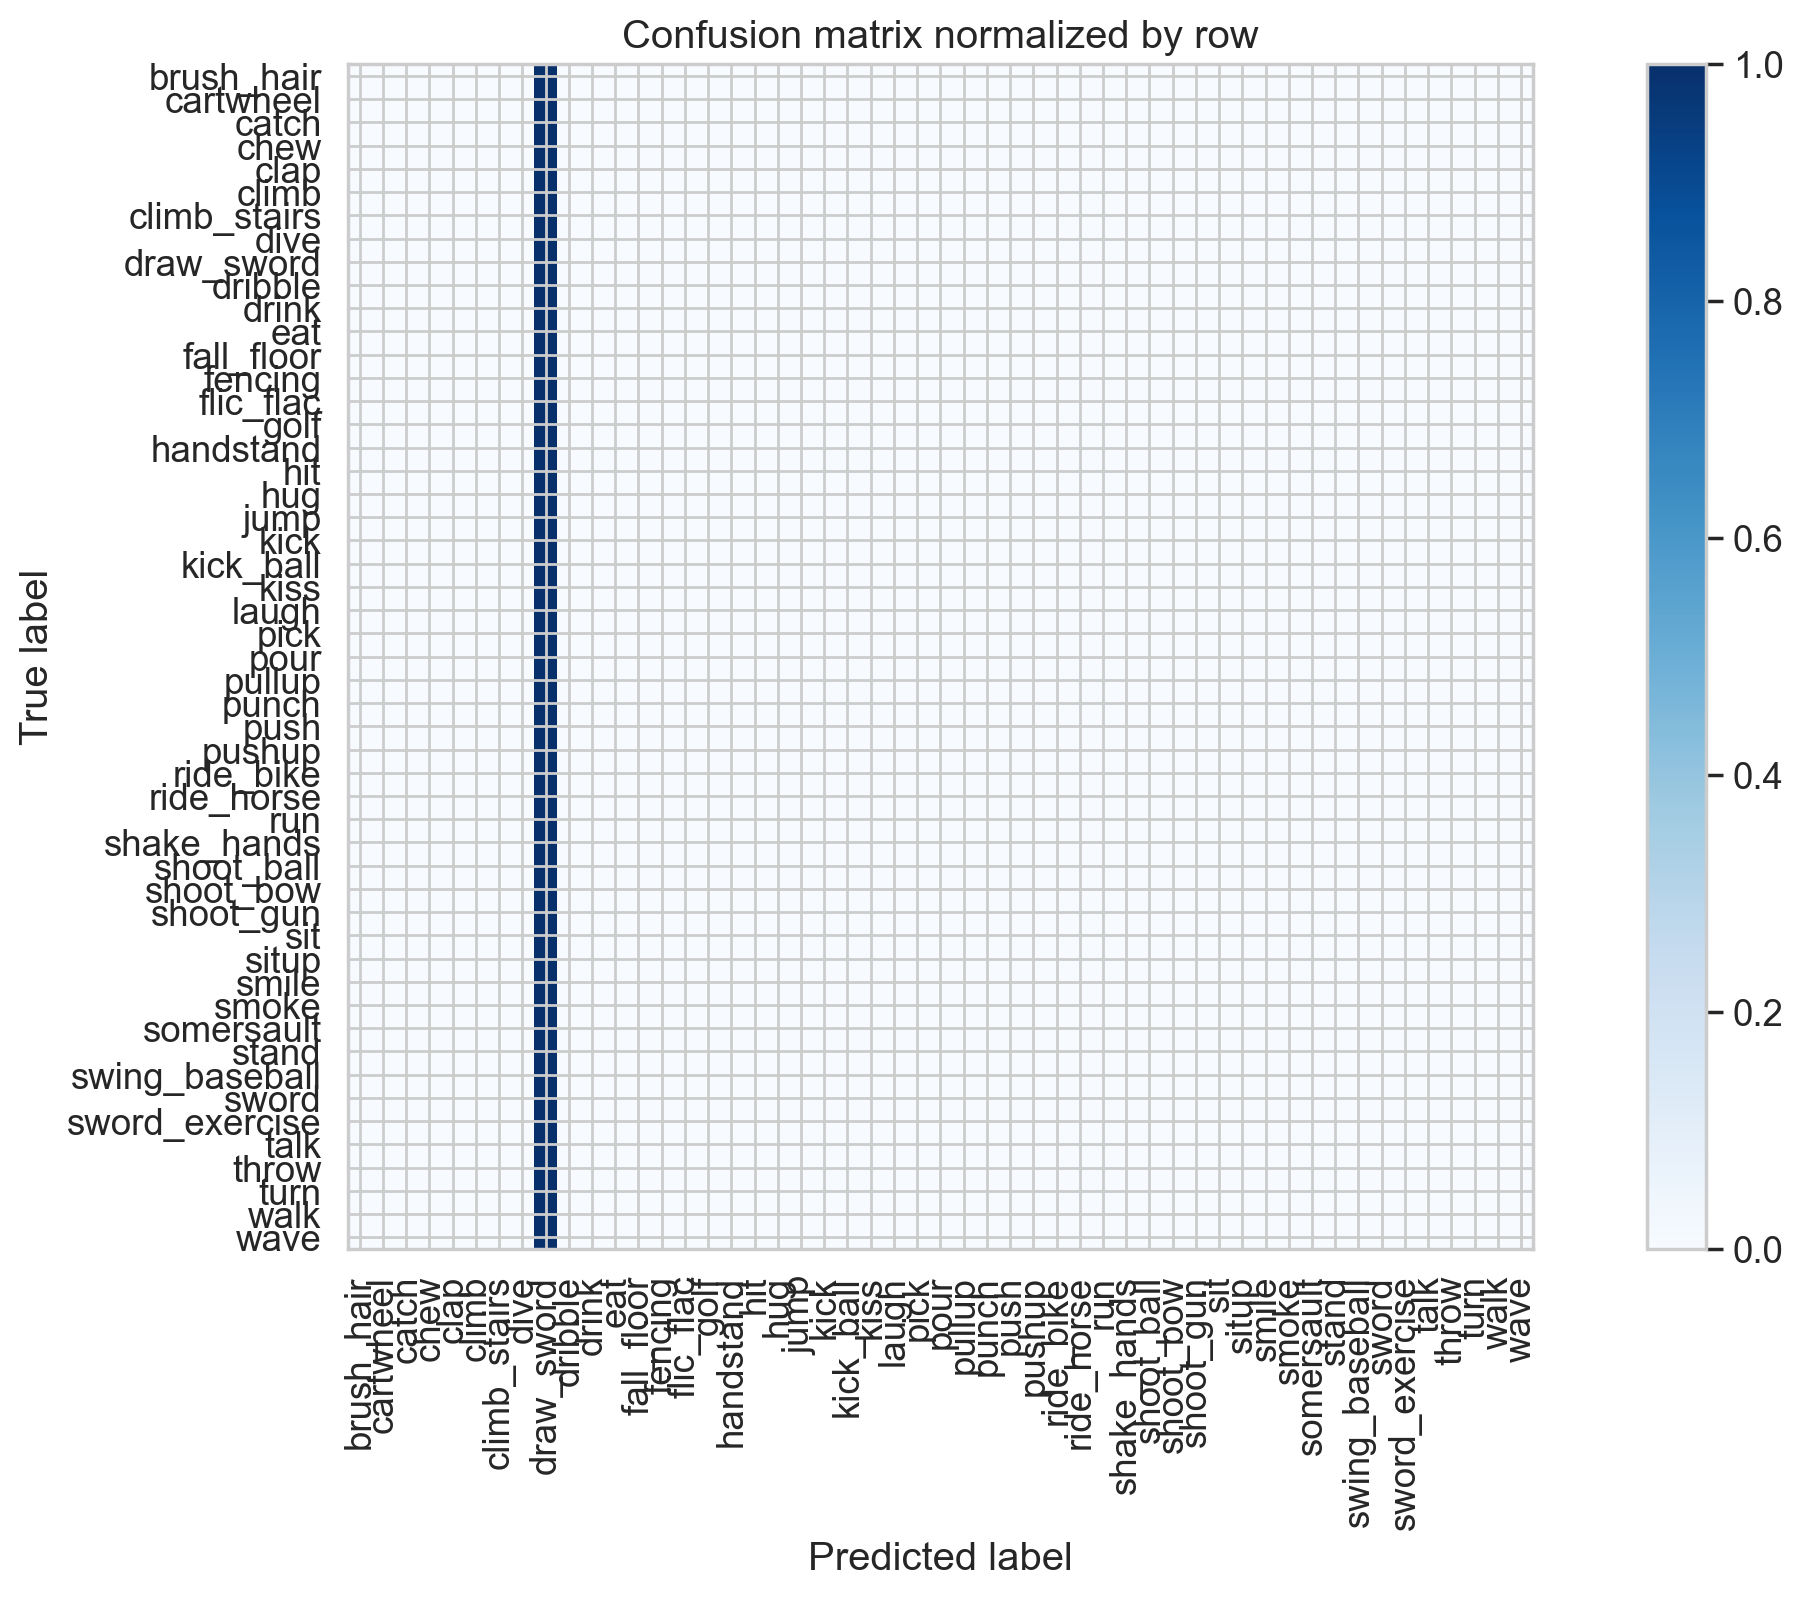

Overall accuracy: 0.016

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walk       0.000      0.000      0.000      0.079         55|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           run       0.000      0.000      0.000      0.034         24|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          turn       0.000      0.000      0.000      0.034         24|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         drink       0.000      0.000      0.000      0.024         17|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
   shake_hands       0.000      0.000      0.000      0.024         17|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          jump       0.000      0.000      0.000      0.023         16|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         stand       0.000      0.000      0.000      0.023         16|	 draw_sword: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.024



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.019



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

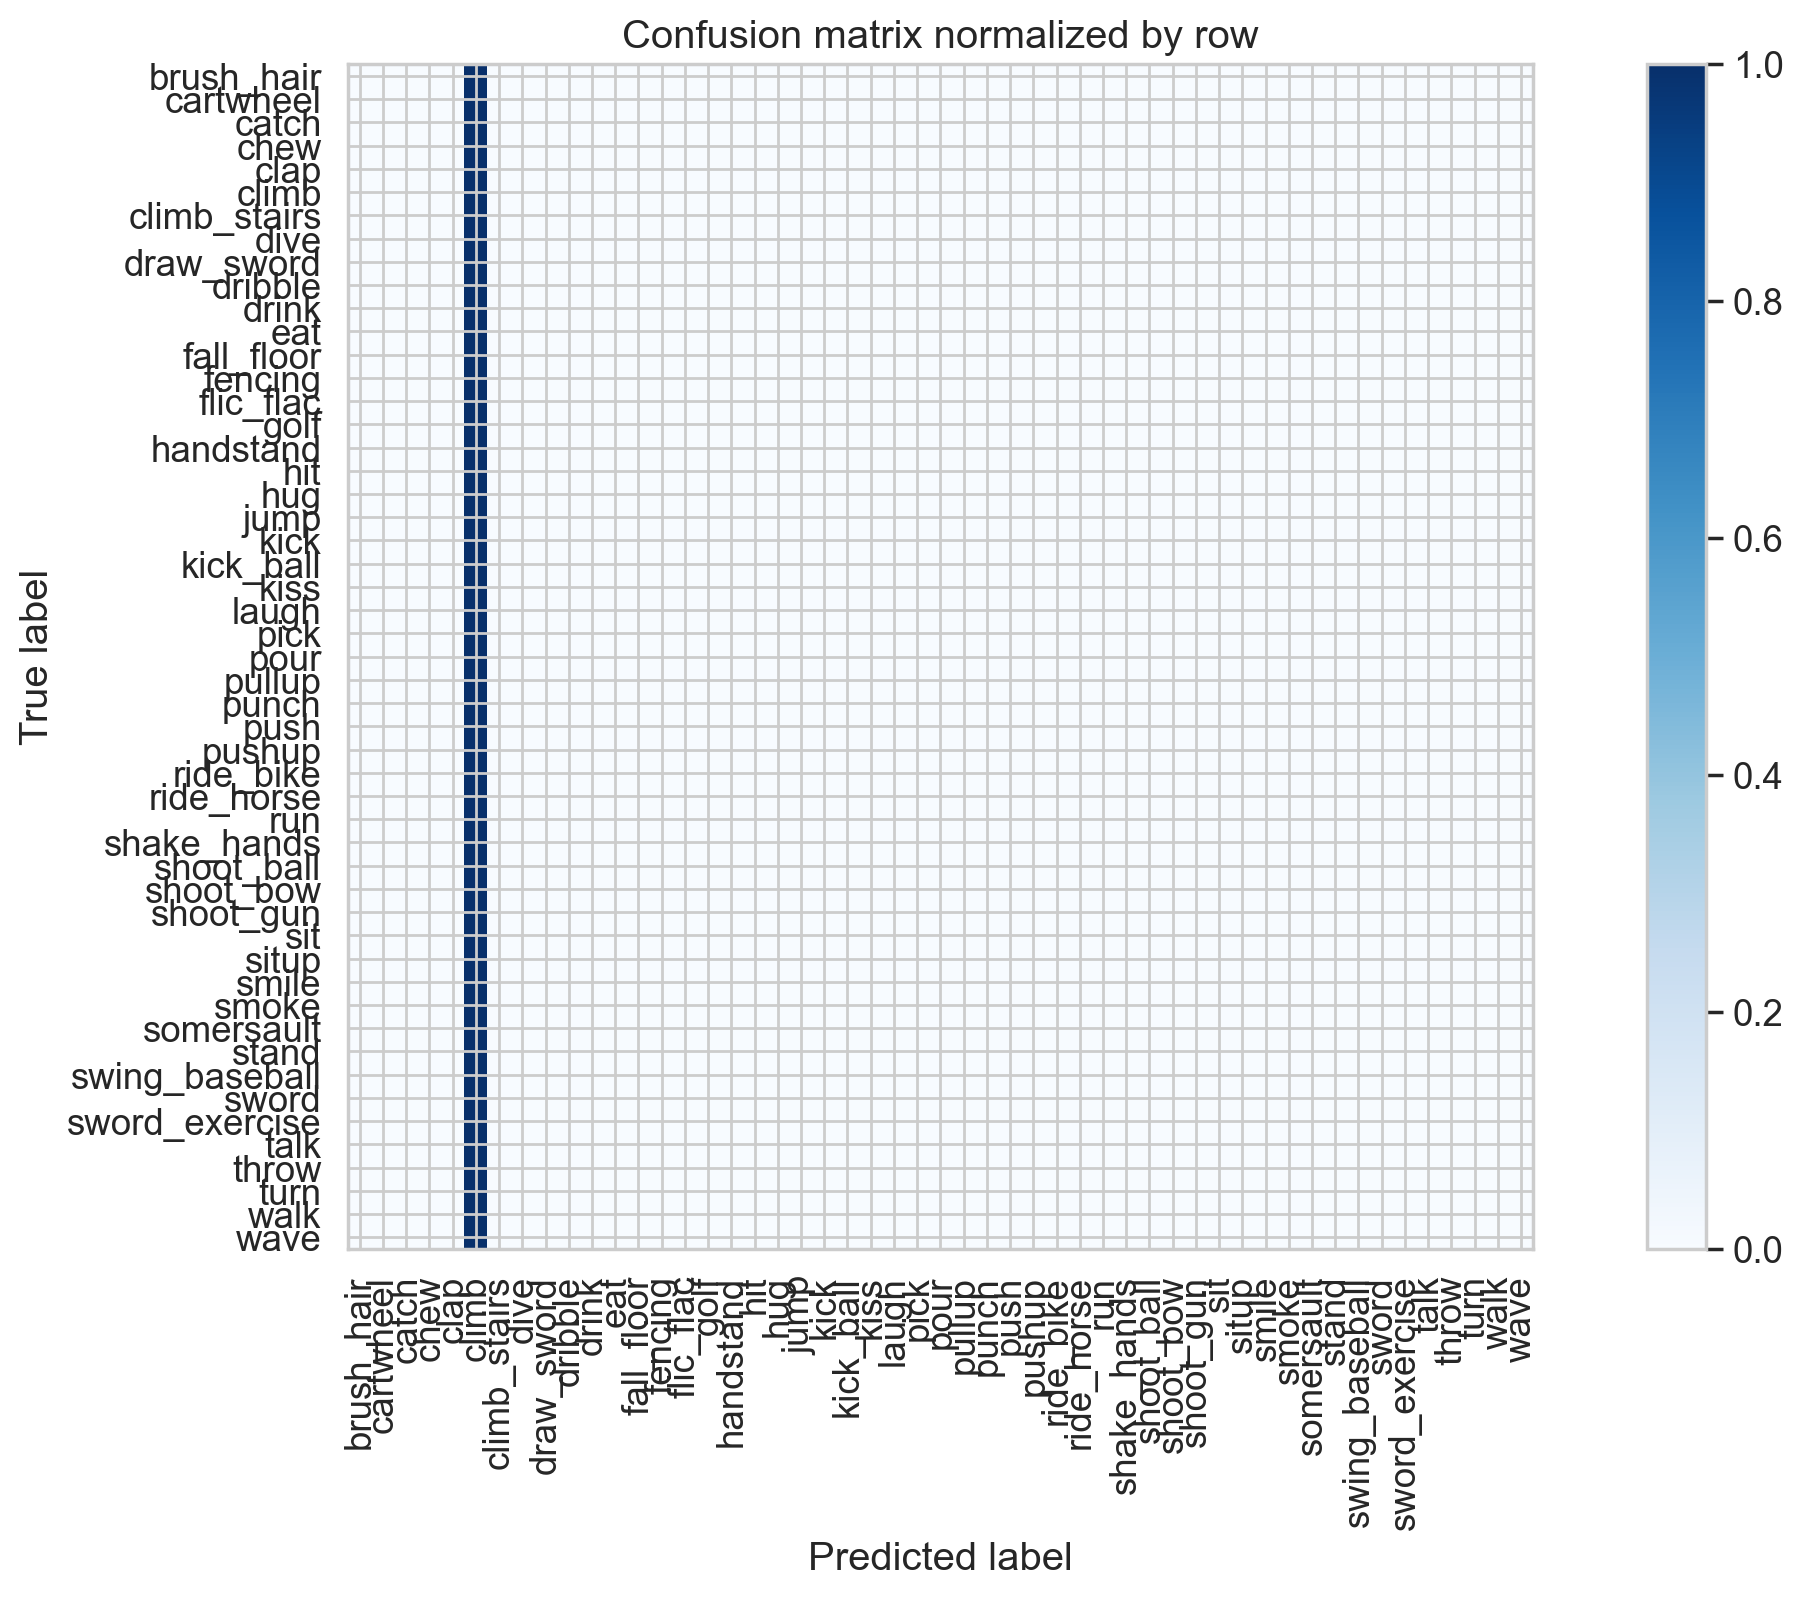

Overall accuracy: 0.016

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walk       0.000      0.000      0.000      0.079         55|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           run       0.000      0.000      0.000      0.034         24|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          turn       0.000      0.000      0.000      0.034         24|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         drink       0.000      0.000      0.000      0.024         17|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
   shake_hands       0.000      0.000      0.000      0.024         17|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          jump       0.000      0.000      0.000      0.023         16|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         stand       0.000      0.000      0.000      0.023         16|	 climb: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           sit       0.000      0.000      0.

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.019



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.024



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.021



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

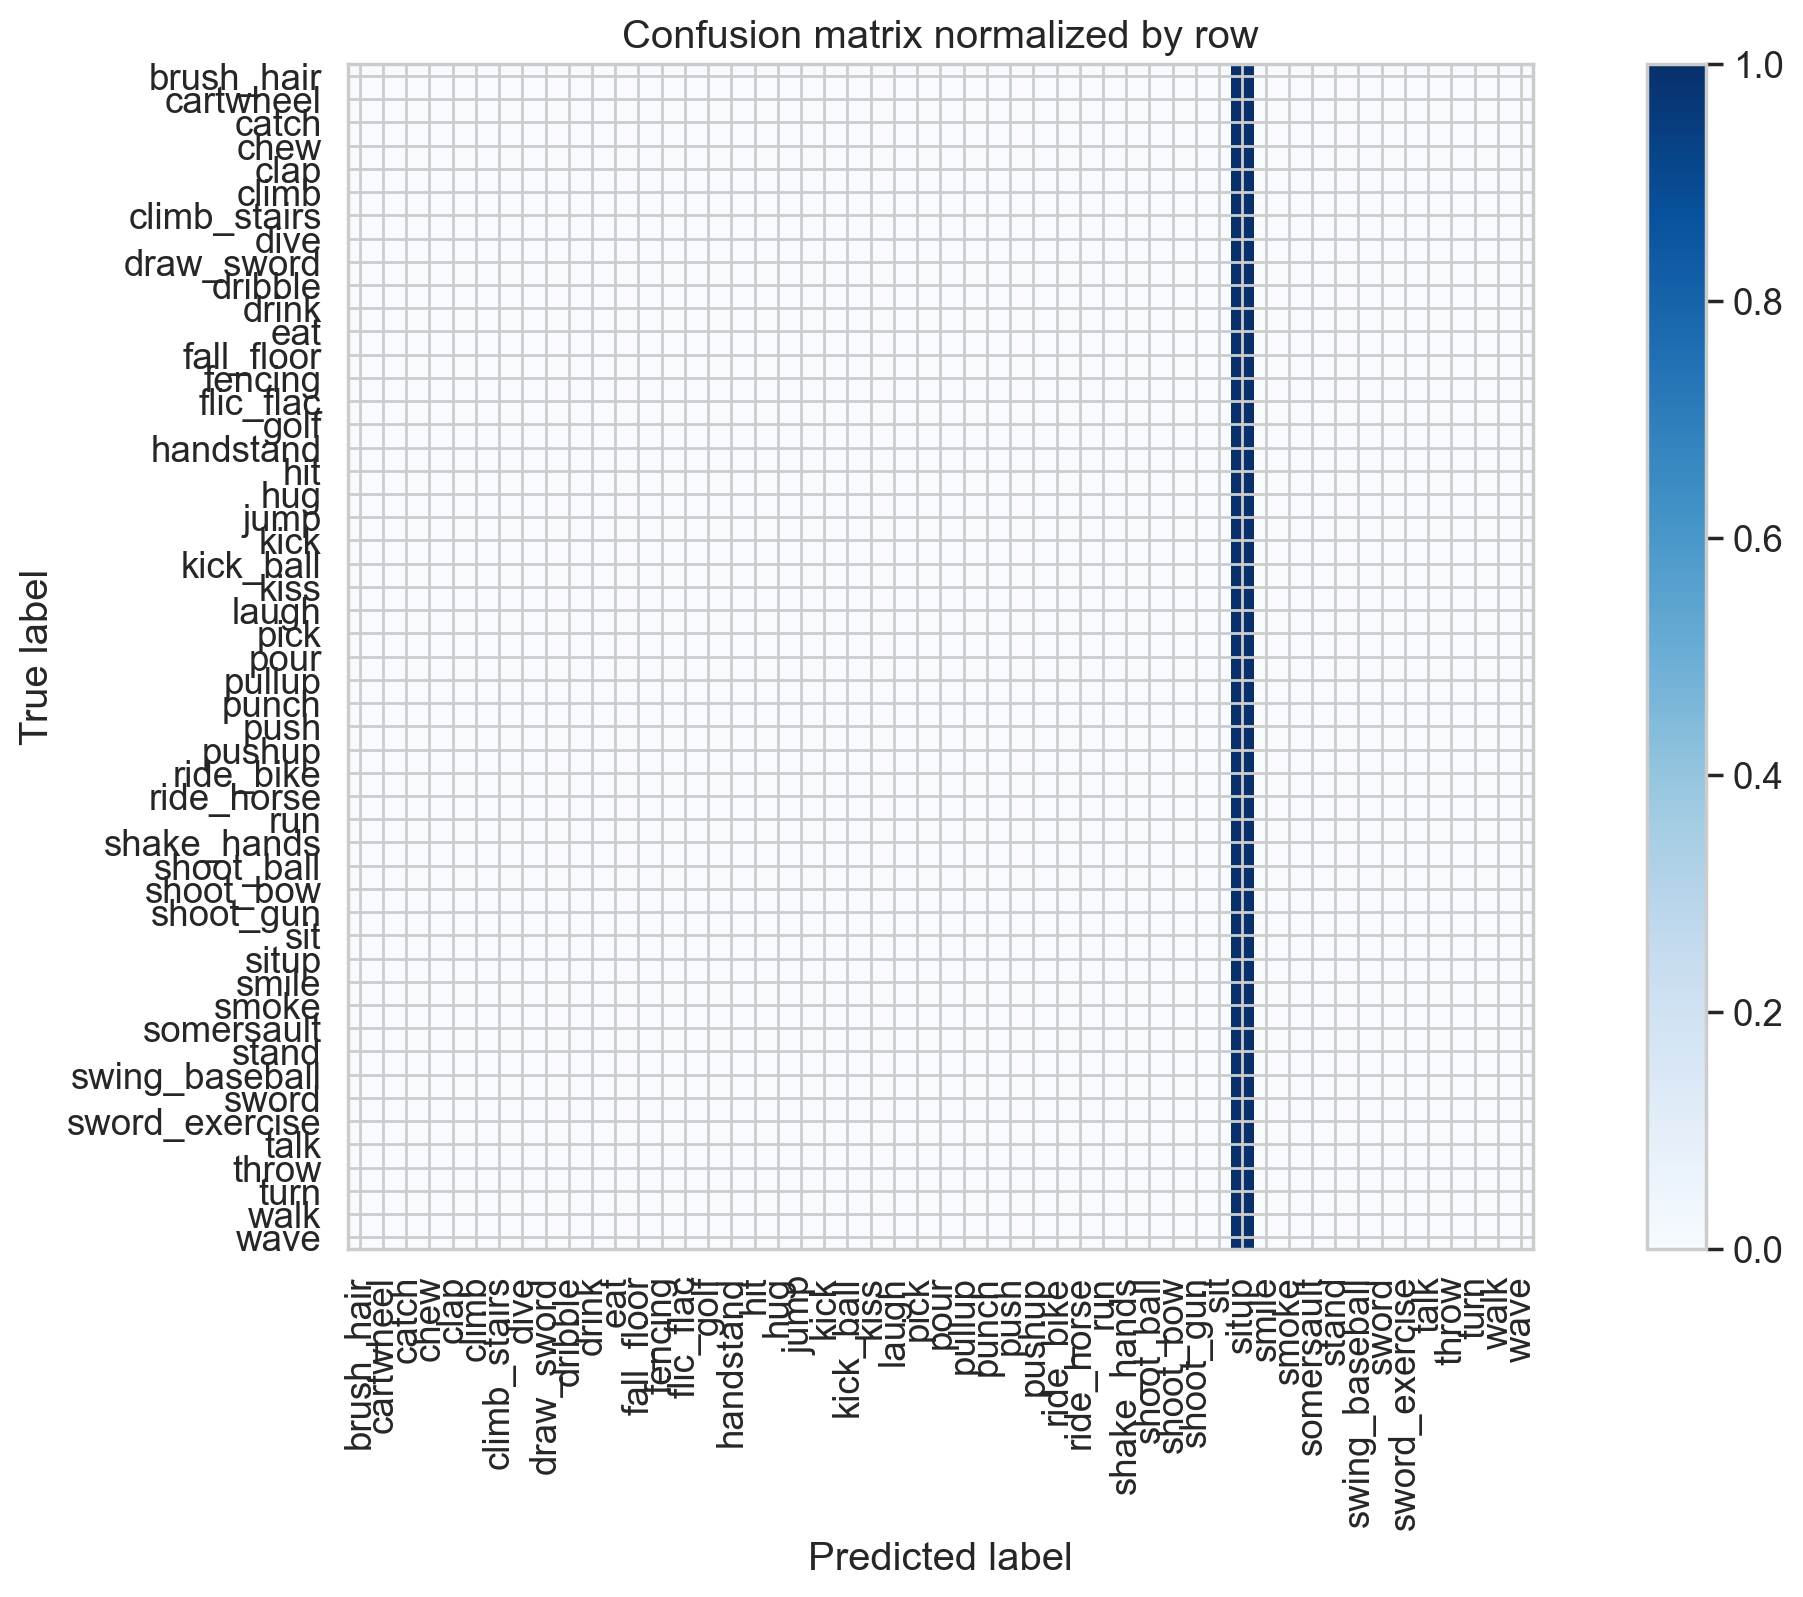

Overall accuracy: 0.016

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walk       0.000      0.000      0.000      0.079         55|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           run       0.000      0.000      0.000      0.034         24|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          turn       0.000      0.000      0.000      0.034         24|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         drink       0.000      0.000      0.000      0.024         17|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
   shake_hands       0.000      0.000      0.000      0.024         17|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
          jump       0.000      0.000      0.000      0.023         16|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
         stand       0.000      0.000      0.000      0.023         16|	 situp: 1.000,	wave: 0.000,	fall_floor: 0.000,	
           sit       0.000      0.000      0.

train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.017



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.020



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.016



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.079



train:   0%|          | 0/190 [00:00<?, ?batch/s]

eval:   0%|          | 0/22 [00:00<?, ?batch/s]

Overall accuracy: 0.020



<All keys matched successfully>

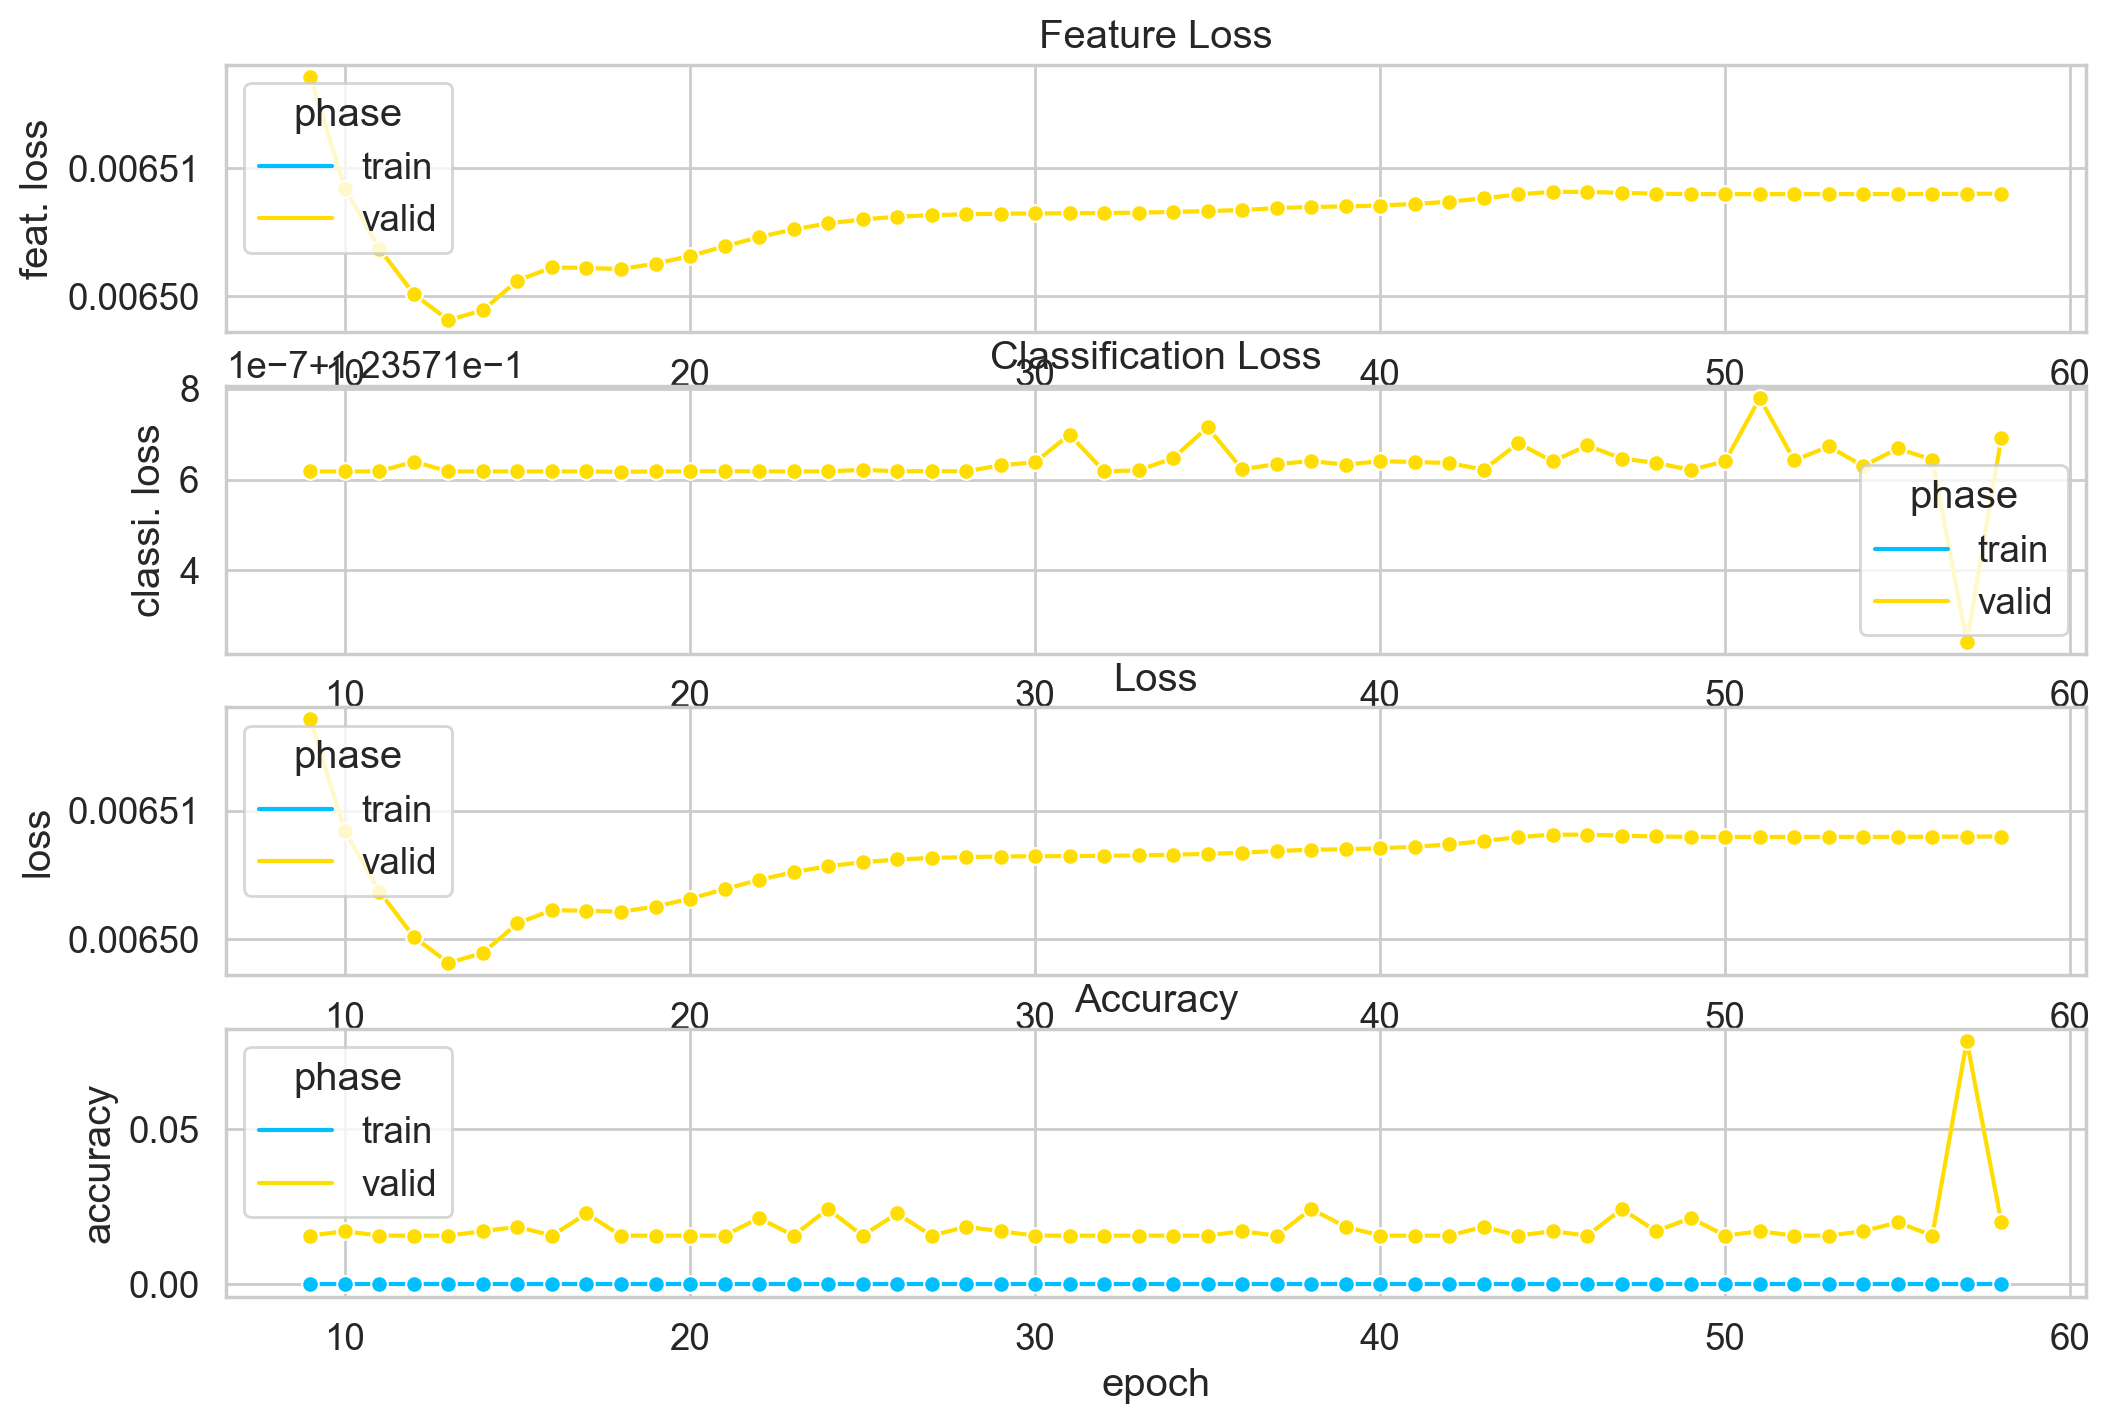

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Communication with Neptune restored!


In [109]:
from tqdm.autonotebook import tqdm

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
show_interval = 10

train_data = []
for epoch in tqdm(range(start_epoch+1, start_epoch+config["n_epochs"] + 1), desc='Training Epoch', leave=False):
  
  train_metrics = train_step(model, train_dl, optimizer, std_loss, device, class_names)
  train_metrics['epoch'] = epoch
  train_metrics['phase'] = 'train'
  train_data.append(train_metrics)
  log(epoch, 'train', train_metrics)
  
  if epoch % 10 == 0:
    eval_metrics = eval_step(model, val_dl,std_loss, device, class_names,  print_report=True, show_plot=True)
  else:
    eval_metrics = eval_step(model, val_dl,std_loss, device, class_names,  print_report=False, show_plot=False)
  eval_metrics['epoch'] = epoch 
  eval_metrics['phase'] = 'valid'
  train_data.append(eval_metrics)
  log(epoch, 'valid', eval_metrics)
  
  save_model(
      model, 
      f"temp_{model_ident}", 
      f"{epoch}__{unique_iden}",
      models_saves, 
      config)
    
  if eval_metrics['accuracy'] > best_acc:
    best_model = copy.deepcopy(model.state_dict())
  
train_df = pd.DataFrame().from_records(train_data)
plot_curves(train_df)

# replace by best model 
model.load_state_dict(best_model)
